In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step


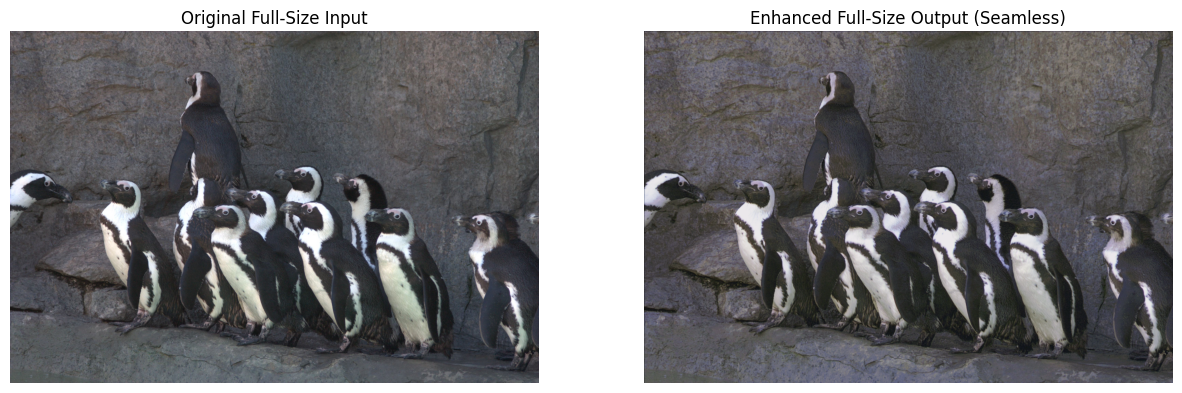

In [7]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
import numpy as np
from PIL import Image

PATCH_SIZE = 128
CHANNELS = 3
BATCH_SIZE = 16
STEP = PATCH_SIZE // 2

TEST_IMAGE_PATH = "/content/drive/MyDrive/Colab Notebooks/FocusAI/test_image.jpg"


def psnr_metric(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)


def ssim_metric(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=1.0)



def patchify_numpy_with_overlap(image, patch_size, step):
    h, w, c = image.shape
    pad_h = (step - (h - patch_size) % step) % step
    pad_w = (step - (w - patch_size) % step) % step

    padded_img = np.pad(image, ((0, pad_h), (0, pad_w), (0, 0)), 'reflect')
    padded_shape = padded_img.shape

    rows = (padded_shape[0] - patch_size) // step + 1
    cols = (padded_shape[1] - patch_size) // step + 1

    patches = []
    for i in range(rows):
        for j in range(cols):
            y = i * step
            x = j * step
            patch = padded_img[y: y + patch_size, x: x + patch_size, :]
            patches.append(patch)

    patches_batch = np.array(patches)

    return patches_batch, (rows, cols), padded_shape, (h, w)


def unpatchify_numpy_with_overlap(patches_batch, grid_shape, padded_shape, original_shape, step):
    """
    Stitches overlapping patches back together with weighted averaging
    (Hanning window) to prevent grid artifacts.
    """
    rows, cols = grid_shape
    original_h, original_w = original_shape

    patch_size = patches_batch.shape[1]
    channels = patches_batch.shape[3]

    enhanced_full_img = np.zeros(padded_shape, dtype=np.float32)
    counts_img = np.zeros(padded_shape, dtype=np.float32)

    window_1d = np.hanning(patch_size)

    window_2d = np.outer(window_1d, window_1d)

    window_3d = np.repeat(window_2d[:, :, np.newaxis], channels, axis=2)

    patch_index = 0
    for i in range(rows):
        for j in range(cols):

            y = i * step
            x = j * step


            enhanced_patch = patches_batch[patch_index]

            enhanced_full_img[y: y + patch_size, x: x + patch_size, :] += (enhanced_patch * window_3d)

            counts_img[y: y + patch_size, x: x + patch_size, :] += window_3d

            patch_index += 1

    enhanced_full_img = enhanced_full_img / (counts_img + 1e-8)

    enhanced_full_img = enhanced_full_img[:original_h, :original_w, :]

    return enhanced_full_img



def main():

    model_path = "/content/drive/MyDrive/Colab Notebooks/FocusAI/enhancer_patch_model_2.keras"
    if not os.path.exists(model_path):
        print(f"Error: Model file not found at '{model_path}'")
        return
    if not os.path.exists(TEST_IMAGE_PATH):
        print(f"Error: Test image not found at '{TEST_IMAGE_PATH}'")
        print("Please set 'TEST_IMAGE_PATH' to a valid file.")
        return


    custom_objects = {"psnr_metric": psnr_metric, "ssim_metric": ssim_metric}
    loaded_model = keras.models.load_model(model_path, custom_objects=custom_objects)


    full_img_pil = Image.open(TEST_IMAGE_PATH).convert('RGB')
    full_img_np = np.array(full_img_pil)
    full_img_normalized = full_img_np.astype(np.float32) / 255.0

    # --- 2. Patchify ---

    input_batch, grid_shape, padded_shape, original_shape = patchify_numpy_with_overlap(
        full_img_normalized, PATCH_SIZE, STEP
    )



    enhanced_batch = loaded_model.predict(input_batch, batch_size=BATCH_SIZE)


    enhanced_full_img = unpatchify_numpy_with_overlap(
        enhanced_batch, grid_shape, padded_shape, original_shape, STEP
    )

    enhanced_full_img = np.clip(enhanced_full_img, 0.0, 1.0)
    img_to_save = (enhanced_full_img * 255).astype(np.uint8)

    pil_img = Image.fromarray(img_to_save)


    output_path = "/content/drive/MyDrive/Colab Notebooks/FocusAI/enhanced_image_5000.png"
    pil_img.save(output_path)


    fig, axes = plt.subplots(1, 2, figsize=(15, 7))
    axes[0].imshow(full_img_normalized)
    axes[0].set_title("Original Full-Size Input")
    axes[0].axis('off')

    axes[1].imshow(enhanced_full_img)
    axes[1].set_title("Enhanced Full-Size Output (Seamless)")
    axes[1].axis('off')

    plt.show()


if __name__ == "__main__":
    main()